In [1]:
!pip install tensorflow tensorflow-datasets scikit-learn numpy seaborn matplotlib pillow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [10]:
IMG_SIZE = (160,160)
BATCH_SIZE = 32

(train_ds, val_ds), info = tfds.load(
    'tf_flowers',
    split=['train[:85%]', 'train[85%:]'],
    with_info=True,
    as_supervised=True
)

def preprocess(img, label):
    img = tf.image.resize(img, IMG_SIZE) / 255.0
    return img, label

train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(1)
class_names = info.features['label'].names

#Get one batch
images, labels = next(iter(train_ds))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Class Names:", class_names)


Images shape: (32, 160, 160, 3)
Labels shape: (32,)
Class Names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [ ]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

model = tf.keras.Sequential([
    base, 
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)

base.summary()
model.summary()

base.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)

Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 212ms/step - accuracy: 0.6204 - loss: 0.9787 - val_accuracy: 0.8545 - val_loss: 0.4376
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.8648 - loss: 0.3798 - val_accuracy: 0.8691 - val_loss: 0.3722
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.9011 - loss: 0.2954 - val_accuracy: 0.8709 - val_loss: 0.3458


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,277,201 (8.69 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 12,812 (50.05 KB)

Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7817 - loss: 0.5945 - val_accuracy: 0.8855 - val_loss: 0.3202
Epoch 2/3
 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9379 - loss: 0.2559

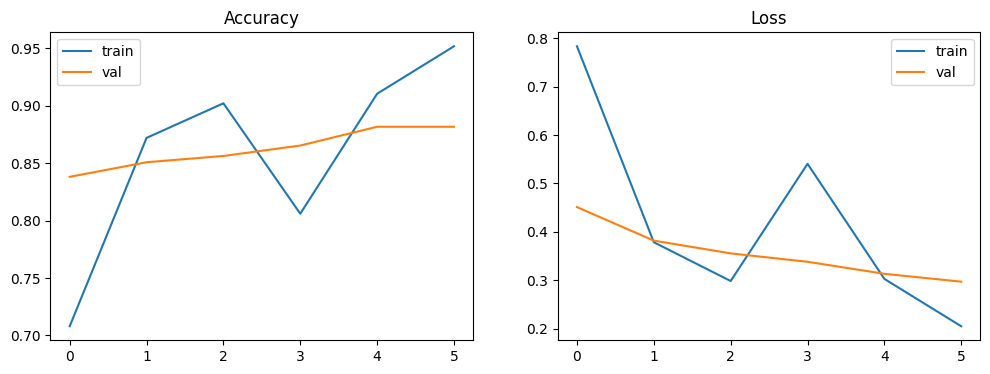

Validation Accuracy:  0.8818181753158569


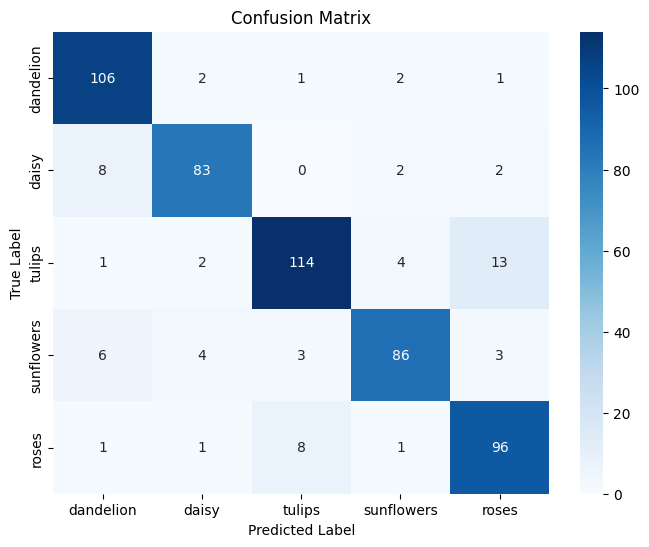

              precision    recall  f1-score   support

   dandelion       0.87      0.95      0.91       112
       daisy       0.90      0.87      0.89        95
      tulips       0.90      0.85      0.88       134
  sunflowers       0.91      0.84      0.87       102
       roses       0.83      0.90      0.86       107

    accuracy                           0.88       550
   macro avg       0.88      0.88      0.88       550
weighted avg       0.88      0.88      0.88       550



In [13]:
train_acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
train_loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Accuracy');
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.title('Loss');
plt.legend()
plt.show();

loss, acc = model.evaluate(val_ds, verbose=0)
print('Validation Accuracy: ',acc)

y_true, y_pred = [], []
for x, y in val_ds:
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(model.predict(x, verbose=0), axis = 1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

In [16]:
test_folders = Path('Test Dataset')
img_types = ("*.jpg", "*.jpeg", "*.png", "*.webp")

def predict(img_path):
    img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
    arr = np.array(img)[np.newaxis] / 255.0
    pred = model.predict(arr, verbose=0)[0]
    cls = class_names[np.argmax(pred)]
    conf = np.max(pred)
    print(f"{img_path.name} -> {cls} ({conf:.3f})")

if test_folders.exists():
    for pattern in img_types:
        for img_path in test_folders.glob(pattern):
            predict(img_path)
else:
    print("Test folder not found.")

Daisy.webp -> daisy (0.999)
Dandelion.webp -> dandelion (0.980)
Rose.webp -> roses (0.842)
Sunflower.webp -> sunflowers (0.965)
Tulip.webp -> tulips (0.995)
